= 必备设置

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from abc import ABC , abstractmethod


def solve_helmholtz_fd(lam, mu, N=2001):
    """
    使用有限差分法求解Helmholtz方程: u'' + λ²u = sin(μx), u(-1)=u(1)=0
    参数:
        lam: λ参数（波数）
        mu: μ参数（源项频率）
        N: 网格点数（奇数，确保包含x=0）
    返回:
        x: 网格点坐标 [N, 1]
        u: 数值解 [N, 1]
    """
    # 创建网格
    x = np.linspace(-1, 1, N)
    dx = x[1] - x[0]
    
    # 构建系数矩阵 A (三对角矩阵)
    main_diag = (-2/dx**2) + lam**2  # 主对角线
    off_diag = 1/dx**2               # 次对角线
    
    diagonals = [
        np.full(N-1, off_diag),    # 下对角线
        np.full(N, main_diag),     # 主对角线
        np.full(N-1, off_diag)     # 上对角线
    ]
    
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')
    
    # 构建右端项 b = sin(μx)
    b = np.sin(mu * x)
    
    # 应用边界条件 u(-1)=u(1)=0
    A[0, :] = 0
    A[0, 0] = 1
    b[0] = 0
    
    A[-1, :] = 0
    A[-1, -1] = 1
    b[-1] = 0
    
    # 求解线性系统
    u = spsolve(A, b)
    
    return x[:, None], u[:, None]
class Solver(nn.Module, ABC):
    """
    神经网络求解器的抽象类（双优化器版本）
    """
    def __init__(self, physical_information=False, if_scale_u=False):
        """
        初始化求解器
        
        参数:
            physical_information: 是否使用物理信息
            if_scale_u: 是否对解进行缩放
        """
        super().__init__()
        self.if_scale_u = if_scale_u
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lam = 205.0
        self.mu = 3.0
        self.lb = -1.0
        self.ub = 1.0
        self.N_fd = 2001
        self.boundary_x = np.array([[-1.0], [1.0]])
        self.boundary_u = np.array([[0.0], [0.0]])
        num_internal_points = 500
        self.x_fd, self.u_fd = solve_helmholtz_fd(self.lam, self.mu, N=self.N_fd)
        indices = np.linspace(0, len(self.x_fd)-1, num_internal_points, dtype=int)
        internal_x = self.x_fd[indices]
        internal_u = self.u_fd[indices]
        x_u = np.vstack([self.boundary_x, internal_x])
        u = np.vstack([self.boundary_u, internal_u])
        self.lb = torch.tensor(self.lb, dtype=torch.float32).to(self.device)
        self.ub = torch.tensor(self.ub, dtype=torch.float32).to(self.device)
        # 注册训练数据
        self.x_u = torch.tensor(x_u, dtype=torch.float32).to(self.device)
        self.u = torch.tensor(u, dtype=torch.float32).to(self.device) 
        self.scaled_u = self.u * 1e5
        self.physical_information = physical_information
        self.x_f = torch.linspace(self.lb, self.ub, 1000).view(-1, 1).to(self.device)
        self.x_f.requires_grad = True
        
        # 双优化器相关参数
        self.optimizer_u = None  # 数据拟合优化器
        self.optimizer_f = None  # 物理约束优化器
        self.scheduler_u = None  # 数据拟合学习率调度器
        self.scheduler_f = None  # 物理约束学习率调度器
        self.physics_ratio = 0.6  # 物理约束更新比例

    @abstractmethod
    def net_u(self, x):
        """子类必须实现此方法，定义神经网络架构和前向传播"""
        pass

    def net_f(self, x):
        """计算PDE残差"""
        u = self.net_u(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        if self.if_scale_u:
            f = u_xx + (self.lam**2) * u - 1e5 * torch.sin(self.mu * x)
        else:
            f = u_xx + (self.lam**2) * u - torch.sin(self.mu * x)
        return f
    
    def setup_dual_optimizers(self, lr_u=5e-4, lr_f=5e-5):
        if not self.physical_information:
            # 非物理信息情况，只使用一个优化器
            self.optimizer_u = torch.optim.Adam(self.parameters(), lr=lr_u)
            self.scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer_u, mode='min', factor=0.5, patience=500
            )
            return
        
        # 物理信息情况，设置双优化器
        # 数据拟合优化器：较大的学习率，更快收敛
        self.optimizer_u = torch.optim.Adam(
            self.parameters(),  
            lr=lr_u,
            betas=(0.9, 0.999),
            weight_decay=1e-6
        )
        
        # 物理约束优化器：较小的学习率，更稳定
        self.optimizer_f = torch.optim.Adam(
            self.parameters(), 
            lr=lr_f,
            betas=(0.95, 0.999),
            weight_decay=1e-5
        )
        
        # 独立的学习率调度器
        self.scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer_u, mode='min', factor=0.5, patience=1000
        )
        self.scheduler_f = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer_f, mode='min', factor=0.5, patience=1000
        )
    
    def compute_losses(self):
        """分别计算数据损失和物理损失"""
        if not self.physical_information:
            if self.if_scale_u:
                u_pred = self.net_u(self.x_u)
                loss_u = torch.mean((self.scaled_u - u_pred) ** 2)
            else:
                u_pred = self.net_u(self.x_u)
                loss_u = torch.mean((self.u - u_pred) ** 2) * 1e10
            return loss_u, None, None
        
        # 物理信息情况
        # 计算物理约束损失
        f_pred = self.net_f(self.x_f)
        loss_f = torch.mean(f_pred**2)
        
        # 计算数据拟合损失
        if self.if_scale_u:
            u_pred = self.net_u(self.x_u)
            loss_u = torch.mean((self.scaled_u - u_pred) ** 2)
        else:
            u_pred = self.net_u(self.x_u)
            loss_u = torch.mean((self.u - u_pred) ** 2) * 1e10
            
        return loss_u, loss_f, loss_u + loss_f
    
    def fit(self, nIter, lr_u=5e-4, lr_f=5e-5):
        """使用双优化器训练网络"""
        super().train()
        self.setup_dual_optimizers(lr_u=lr_u, lr_f=lr_f)
        
        history = {
            'total_loss': [],
            'loss_u': [],
            'loss_f': []
        }
        
        # 训练循环
        for i in range(nIter):
            # 计算当前损失
            loss_u, loss_f, total_loss = self.compute_losses()
            
            if self.physical_information:
                # 交替优化策略：先物理约束，后数据拟合
                num_physics_steps = max(1, int(self.physics_ratio * 2))
                num_data_steps = max(1, int((1 - self.physics_ratio) * 2))
                
                # 物理约束更新
                for _ in range(num_physics_steps):
                    self.optimizer_f.zero_grad()
                    f_pred = self.net_f(self.x_f)
                    loss_f = torch.mean(f_pred**2)
                    loss_f.backward()
                    # 梯度裁剪
                    torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)
                    self.optimizer_f.step()
                
                # 数据拟合更新
                for _ in range(num_data_steps):
                    self.optimizer_u.zero_grad()
                    if self.if_scale_u:
                        u_pred = self.net_u(self.x_u)
                        loss_u = torch.mean((self.scaled_u - u_pred) ** 2)
                    else:
                        u_pred = self.net_u(self.x_u)
                        loss_u = torch.mean((self.u - u_pred) ** 2) * 1e10
                    loss_u.backward()
                    # 梯度裁剪
                    torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                    self.optimizer_u.step()
                
                # 动态调整物理更新比例（训练后期减少物理约束权重）
                if i > 5000:
                    self.physics_ratio = max(0.3, self.physics_ratio * 0.999)
                
                # 调度学习率
                self.scheduler_f.step(loss_f)
                self.scheduler_u.step(loss_u)
                
                # 记录历史
                history['total_loss'].append((loss_u + loss_f).item())
                history['loss_u'].append(loss_u.item())
                history['loss_f'].append(loss_f.item())
                
            else:
                # 非物理信息情况，使用单优化器
                self.optimizer_u.zero_grad()
                loss_u.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                self.optimizer_u.step()
                self.scheduler_u.step(loss_u)
                
                # 记录历史
                history['total_loss'].append(loss_u.item())
                history['loss_u'].append(loss_u.item())
                history['loss_f'].append(0.0)
            
            # 打印训练过程
            if (i+1) % 500 == 0:
                if self.physical_information:
                    lr_u_val = self.optimizer_u.param_groups[0]['lr']
                    lr_f_val = self.optimizer_f.param_groups[0]['lr']
                    print(f'Iter {i+1}/{nIter}, Total Loss: {(loss_u + loss_f).item():.3e}, '
                          f'Loss_u: {loss_u.item():.3e}, Loss_f: {loss_f.item():.3e}, '
                          f'LR_u: {lr_u_val:.2e}, LR_f: {lr_f_val:.2e}, Ratio: {self.physics_ratio:.2f}')
                else:
                    lr_val = self.optimizer_u.param_groups[0]['lr']
                    print(f'Iter {i+1}/{nIter}, Loss: {loss_u.item():.3e}, LR: {lr_val:.2e}')
        
        # 绘制结果
        self.plot(history)       
        return history
    
    def predict(self, x):
        """预测结果"""
        super().eval()
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            u = self.net_u(x_tensor)
        return u.cpu().numpy() * 1e-5 if self.if_scale_u else u.cpu().numpy()
    
    def plot(self, history):
        """绘制预测结果和训练历史"""
        u_pred = self.predict(self.x_fd)
        
        # 创建结果图
        plt.figure(figsize=(12, 10))
        plt.plot(self.x_fd, self.u_fd, 'k-', label='Finite Difference Solution', linewidth=2)
        plt.plot(self.x_fd, u_pred, 'b--', label='DNN Prediction', linewidth=2)
        plt.scatter(self.x_u.detach().cpu().numpy(), 
                   self.u.detach().cpu().numpy(), 
                   color='red', s=20, zorder=5, label='Training Points')
        plt.xlabel('x', fontsize=14)
        plt.ylabel('u(x)', fontsize=14)
        title = f'Helmholtz Equation Solution: λ={self.lam}, μ={self.mu}'
        if self.physical_information:
            title += ' (Physics-Informed)'
        else:
            title += ' (Data-Driven)'
        plt.title(title, fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # 创建损失历史图
        plt.figure(figsize=(10, 6))
        if self.physical_information:
            plt.semilogy(history['total_loss'], 'k-', label='Total Loss', linewidth=2)
            plt.semilogy(history['loss_u'], 'b--', label='Data Loss (Loss_u)', linewidth=2)
            plt.semilogy(history['loss_f'], 'r-.', label='Physics Loss (Loss_f)', linewidth=2)
        else:
            plt.semilogy(history['total_loss'], 'k-', label='Loss', linewidth=2)
        
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Loss (log scale)', fontsize=14)
        plt.title('Training Loss History', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # 计算并显示误差统计
        if self.physical_information:
            with torch.no_grad():
                error = np.abs(u_pred - self.u_fd)
                max_error = np.max(error)
                mean_error = np.mean(error)
                print(f"Maximum absolute error: {max_error:.3e}")
                print(f"Mean absolute error: {mean_error:.3e}")

= 简单DNN

In [58]:
class DNNSolver(Solver):
    def __init__(self,layers):
        super().__init__()
        modules=[]
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i],layers[i+1]))
            if i<len(layers)-2:
                modules.append(nn.Tanh())
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_norm=2.0*(x-self.lb)/(self.ub-self.lb)-1.0
        u=self.net(x_norm)
        return u

Iter 500/10000, Loss: 2.002e+04, LR: 5.00e-04
Iter 1000/10000, Loss: 8.620e+03, LR: 2.50e-04
Iter 1500/10000, Loss: 8.384e+02, LR: 1.25e-04
Iter 2000/10000, Loss: 1.715e+02, LR: 6.25e-05
Iter 2500/10000, Loss: 3.472e+02, LR: 6.25e-05
Iter 3000/10000, Loss: 4.255e+02, LR: 6.25e-05
Iter 3500/10000, Loss: 8.216e+01, LR: 6.25e-05
Iter 4000/10000, Loss: 6.843e+02, LR: 6.25e-05
Iter 4500/10000, Loss: 1.798e+03, LR: 6.25e-05
Iter 5000/10000, Loss: 6.612e+02, LR: 6.25e-05
Iter 5500/10000, Loss: 5.499e+01, LR: 3.13e-05
Iter 6000/10000, Loss: 5.913e+01, LR: 3.13e-05
Iter 6500/10000, Loss: 4.561e+01, LR: 3.13e-05
Iter 7000/10000, Loss: 1.267e+01, LR: 1.56e-05
Iter 7500/10000, Loss: 3.488e+01, LR: 1.56e-05
Iter 8000/10000, Loss: 6.732e+00, LR: 1.56e-05
Iter 8500/10000, Loss: 1.303e+01, LR: 1.56e-05
Iter 9000/10000, Loss: 7.492e+00, LR: 1.56e-05
Iter 9500/10000, Loss: 1.146e+02, LR: 1.56e-05
Iter 10000/10000, Loss: 3.339e+00, LR: 1.56e-05


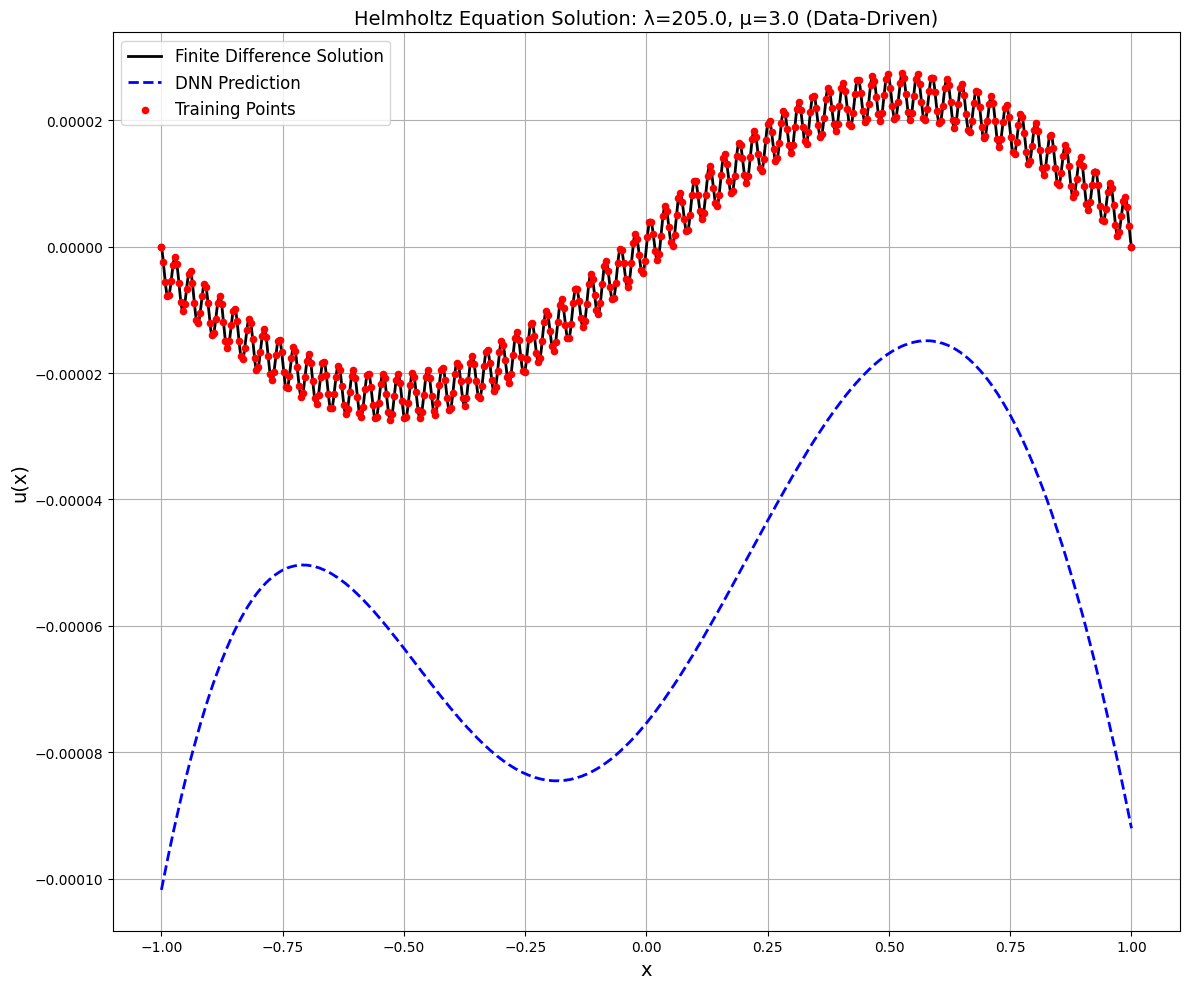

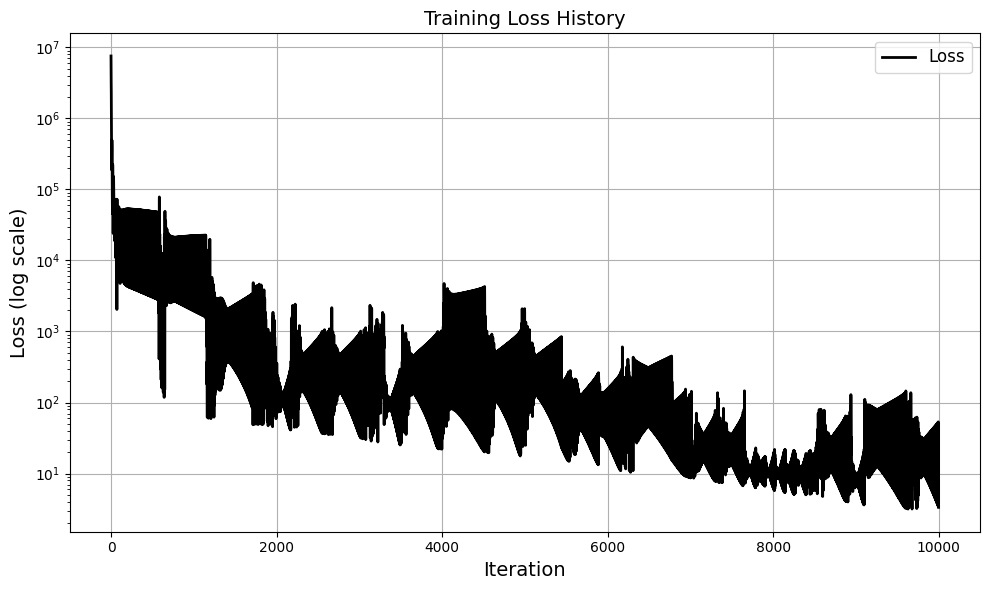

In [61]:
layers=[1,16,32,32,16,1]
dnn_solver=DNNSolver(layers)
dnn_solver.if_scale_u=False 
dnn_solver.physical_information=False
history=dnn_solver.fit(10000)

Iter 500/10000, Loss: 2.871e-01, LR: 5.00e-04
Iter 1000/10000, Loss: 7.071e-02, LR: 5.00e-04
Iter 1500/10000, Loss: 6.842e-02, LR: 5.00e-04
Iter 2000/10000, Loss: 6.794e-02, LR: 5.00e-04
Iter 2500/10000, Loss: 6.769e-02, LR: 5.00e-04
Iter 3000/10000, Loss: 6.758e-02, LR: 5.00e-04
Iter 3500/10000, Loss: 6.752e-02, LR: 5.00e-04
Iter 4000/10000, Loss: 6.748e-02, LR: 5.00e-04
Iter 4500/10000, Loss: 6.746e-02, LR: 5.00e-04
Iter 5000/10000, Loss: 6.744e-02, LR: 5.00e-04
Iter 5500/10000, Loss: 6.743e-02, LR: 5.00e-04
Iter 6000/10000, Loss: 6.741e-02, LR: 5.00e-04
Iter 6500/10000, Loss: 6.741e-02, LR: 5.00e-04
Iter 7000/10000, Loss: 6.739e-02, LR: 5.00e-04
Iter 7500/10000, Loss: 6.737e-02, LR: 5.00e-04
Iter 8000/10000, Loss: 6.736e-02, LR: 5.00e-04
Iter 8500/10000, Loss: 6.735e-02, LR: 5.00e-04
Iter 9000/10000, Loss: 6.733e-02, LR: 5.00e-04
Iter 9500/10000, Loss: 6.731e-02, LR: 5.00e-04
Iter 10000/10000, Loss: 6.728e-02, LR: 5.00e-04


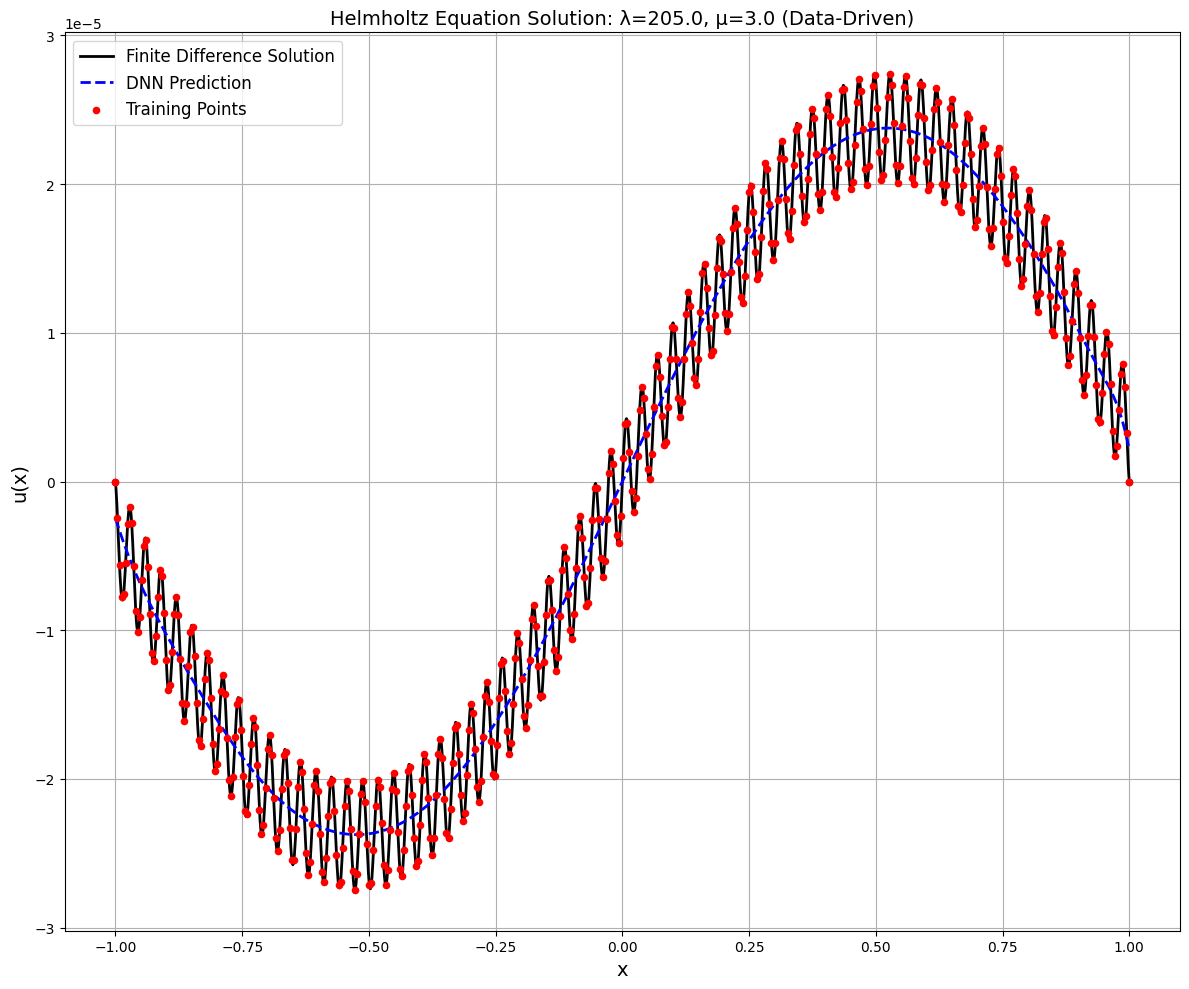

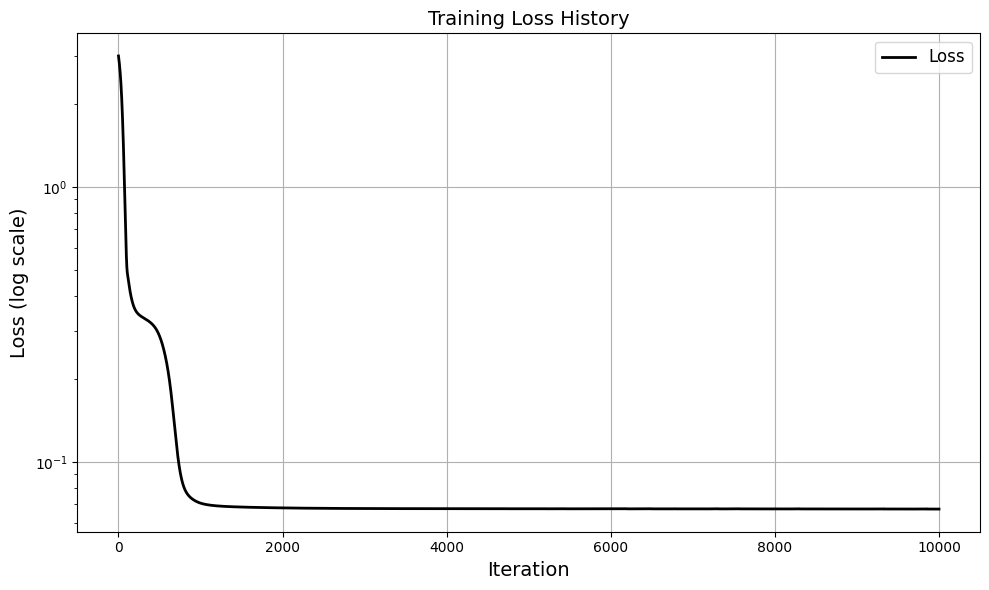

In [60]:
layers=[1,16,32,32,16,1]
dnn_solver=DNNSolver(layers)
dnn_solver.if_scale_u=True 
history=dnn_solver.fit(10000)

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iter 500/10000, Loss: 6.296e+02, LR: 1.00e-03
Iter 1000/10000, Loss: 4.266e+02, LR: 1.00e-03
Iter 1500/10000, Loss: 2.583e+02, LR: 1.00e-03
Iter 2000/10000, Loss: 1.395e+02, LR: 1.00e-03
Iter 2500/10000, Loss: 6.648e+01, LR: 1.00e-03
Iter 3000/10000, Loss: 2.771e+01, LR: 1.00e-03
Iter 3500/10000, Loss: 1.072e+01, LR: 1.00e-03
Iter 4000/10000, Loss: 4.919e+00, LR: 1.00e-03
Iter 4500/10000, Loss: 3.377e+00, LR: 1.00e-03
Iter 5000/10000, Loss: 2.898e+00, LR: 1.00e-03
Iter 5500/10000, Loss: 2.553e+00, LR: 1.00e-03
Iter 6000/10000, Loss: 4.965e+00, LR: 1.00e-03
Iter 6500/10000, Loss: 1.346e+00, LR: 1.00e-03
Iter 7000/10000, Loss: 2.237e+00, LR: 1.00e-03
Iter 7500/10000, Loss: 6.324e-01, LR: 1.00e-03
Iter 8000/10000, Loss: 2.740e-01, LR: 1.00e-03
Iter 8500/10000, Loss: 1.902e-01, LR: 1.00e-03
Iter 9000/10000, Loss: 5.251e-02, LR: 1.00e-03
Iter 9500/10000, Loss: 2.825e+03, LR: 1.00e-03
Iter 10000/10000, Loss: 1.137e-02, LR: 1.00e-03


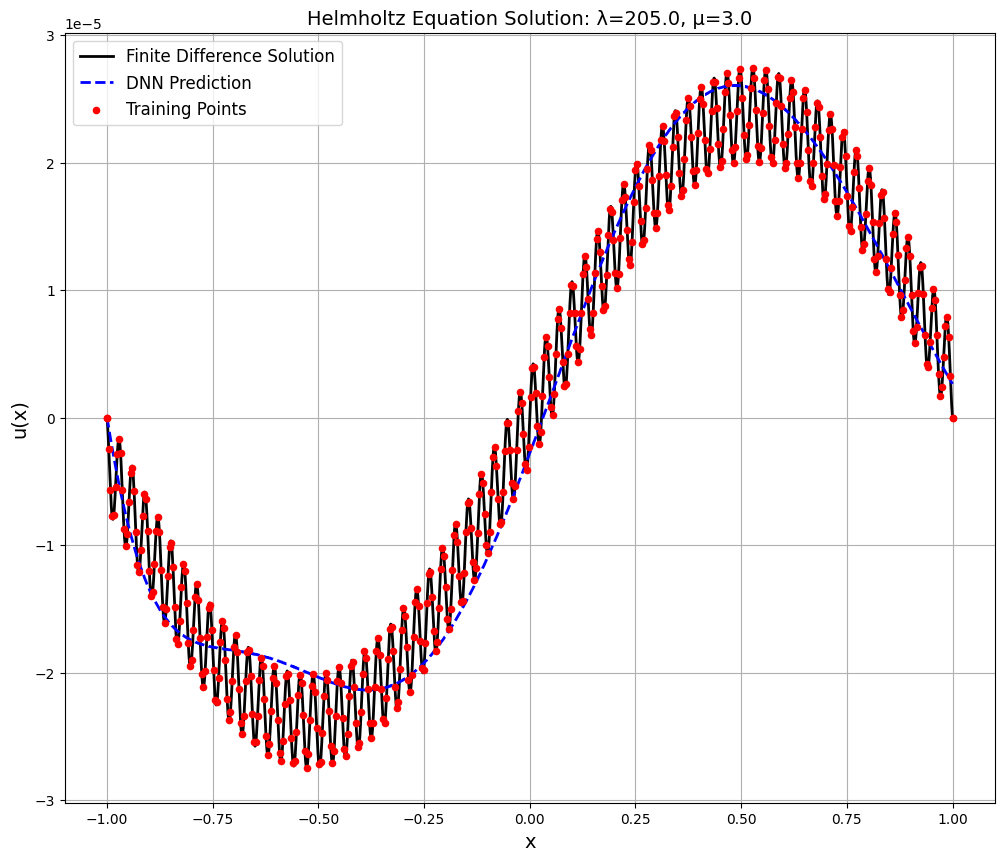

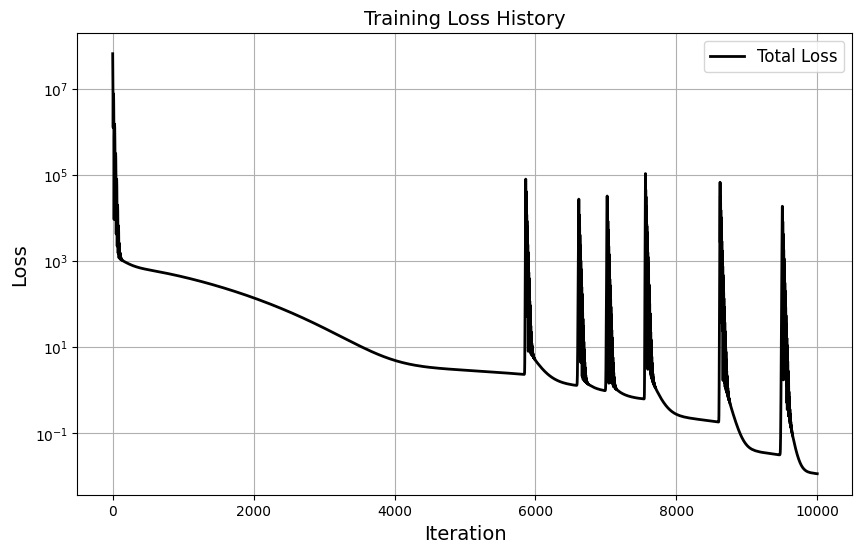

In [23]:
layers=[1,16,32,32,16,1]
dnn_solver=DNNSolver(layers)
dnn_solver.physical_information=True 
dnn_solver.if_scale_u=False 
history=dnn_solver.fit(10000)

Iter 500/10000, Total Loss: 3.481e+08, Loss_u: 2.748e-01, Loss_f: 3.481e+08, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 1000/10000, Total Loss: 3.559e+06, Loss_u: 7.027e-02, Loss_f: 3.559e+06, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 1500/10000, Total Loss: 1.241e+06, Loss_u: 6.864e-02, Loss_f: 1.241e+06, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 2000/10000, Total Loss: 6.589e+05, Loss_u: 6.816e-02, Loss_f: 6.589e+05, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 2500/10000, Total Loss: 4.434e+05, Loss_u: 6.790e-02, Loss_f: 4.434e+05, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 3000/10000, Total Loss: 2.450e+05, Loss_u: 6.774e-02, Loss_f: 2.450e+05, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 3500/10000, Total Loss: 2.026e+05, Loss_u: 6.766e-02, Loss_f: 2.026e+05, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 4000/10000, Total Loss: 1.698e+05, Loss_u: 6.763e-02, Loss_f: 1.698e+05, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 4500/10000, Total Lo

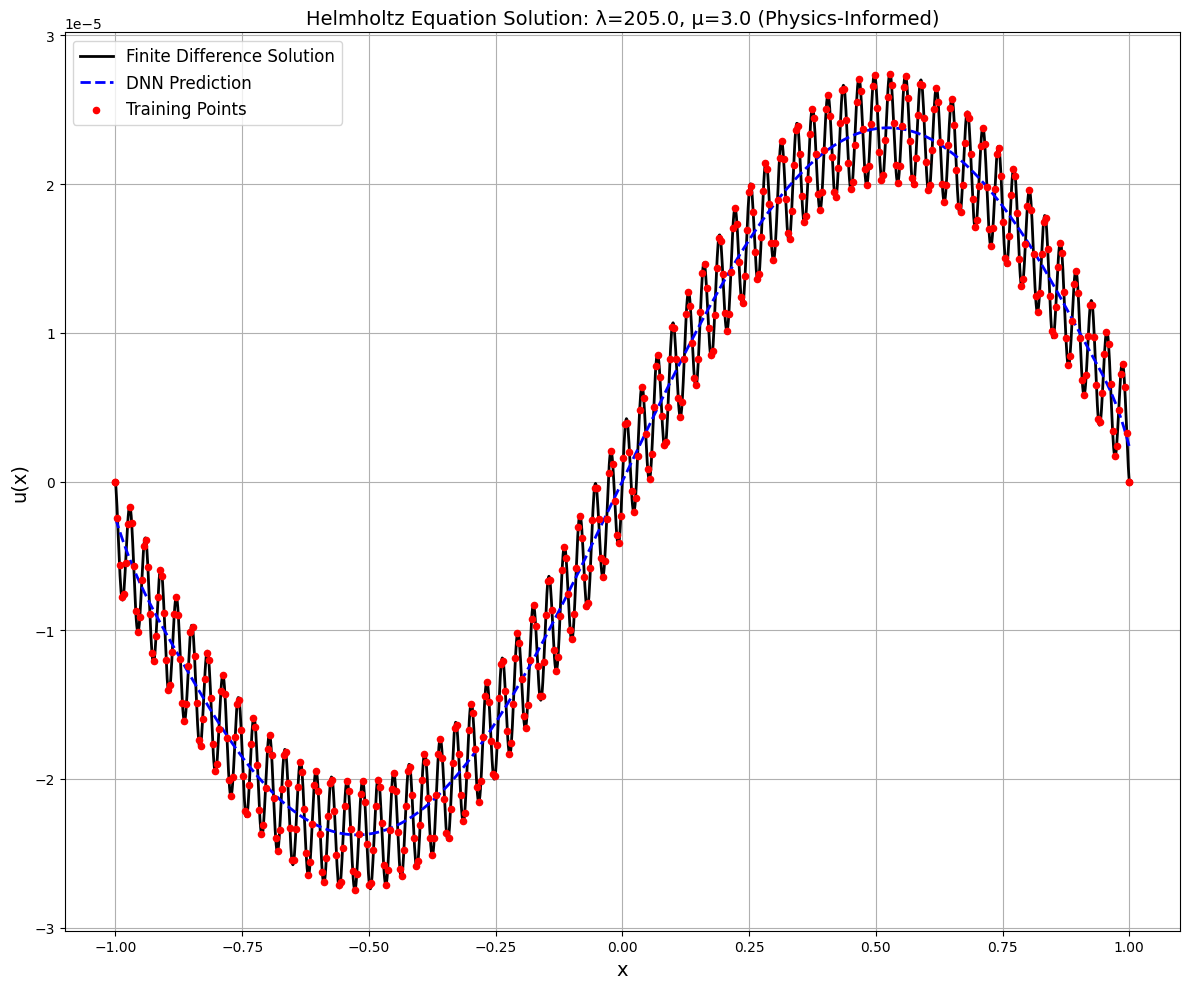

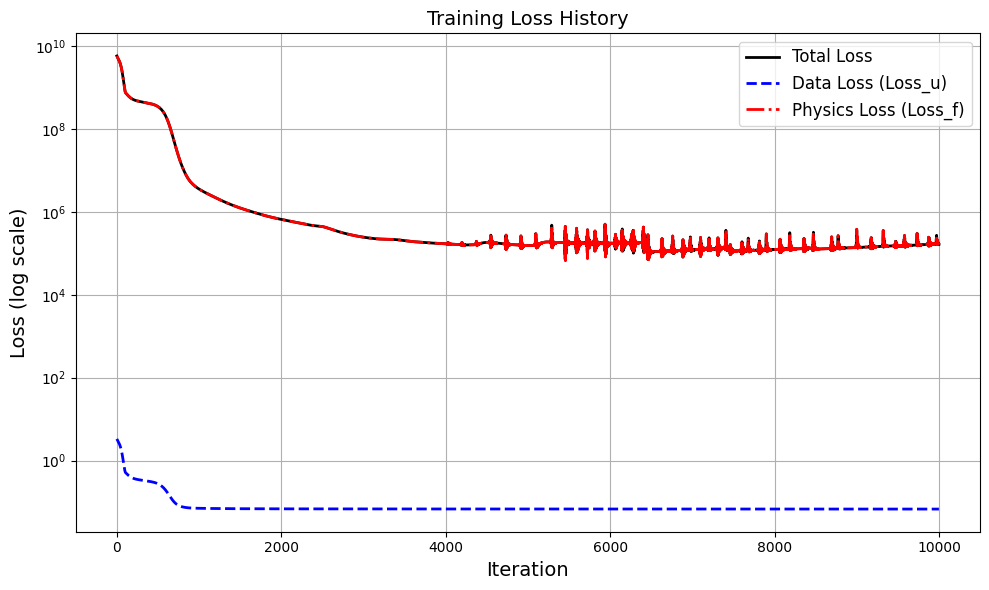

Maximum absolute error: 4.121e-06
Mean absolute error: 2.334e-06


In [55]:
layers=[1,16,32,32,16,1]
dnn_solver=DNNSolver(layers)
dnn_solver.physical_information=True 
dnn_solver.if_scale_u=True
history=dnn_solver.fit(10000)

= 加入随机傅里叶特征

In [52]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        base_freqs=(torch.rand(self.base_feature_dim,input_dim)-0.5)*2.0*np.pi
        all_freqs=[]
        for k in range(1,num_scales+1):
            scale=2.0**k
            all_freqs.append(scale*base_freqs)
        self.register_buffer('omega',torch.cat(all_freqs,dim=0))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega}")
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi
        self.register_buffer('phases',phases)
        with torch.no_grad():
            beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)
        self.beta=nn.Parameter(beta)
        self.scale=torch.sqrt(torch.tensor(2.0/self.total_feature_dim,dtype=torch.float32))
    def forward(self, x):
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * self.beta
        return features
class FourierFeatureSolver(Solver):
    def __init__(self,layers,base_feature_dim,num_scales):
        super().__init__()
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=1,base_feature_dim=base_feature_dim,num_scales=num_scales)
        input_dim=self.multi_scale_fourier_layer.total_feature_dim
        modules=[]
        modules.append(nn.Linear(input_dim,layers[0]))
        for i in range(0,len(layers)-1):
            modules.append(nn.ReLU())
            modules.append(nn.Linear(layers[i],layers[i+1]))
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_norm=2.0*(x-self.lb)/(self.ub-self.lb)-1.0
        x_features=self.multi_scale_fourier_layer(x_norm)
        u=self.net(x_features)
        return u

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_12824\2441497921.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[ 2.6730e+00],
        [-1.6956e+00],
        [-4.5745e+00],
        [-4.8691e+00],
        [ 4.3666e+00],
        [ 1.9806e-01],
        [ 2.7427e+00],
        [ 2.1671e+00],
        [-2.0584e+00],
        [-7.8317e-01],
        [ 6.0427e+00],
        [ 1.5595e+00],
        [-1.7101e-01],
        [ 1.9558e+00],
        [-3.3569e+00],
        [ 5.2741e+00],
        [-5.6237e+00],
        [-3.5476e+00],
        [-7.0315e-01],
        [ 3.0584e-01],
        [ 2.1300e-01],
        [-2.7547e+00],
        [-5.9086e+00],
        [-1.3771e+00],
        [-5.4391e+00],
        [ 4.9350e+00],
        [-3.9384e+00],
        [-5.9816e+00],
        [ 6.1527e+00],
        [ 1.6963e+00],
        [-1.9483e+00],
        [-1.4578e+00],
        [ 5.3459e+00],
        [-3.3912e+00],
        [-9.1489e+00],
        [-9.7382e+00],
        [ 8.7331e+00],
        [ 3.9612e-01],
        [ 5.4853e+00],
        [ 4.3343e+00],
        [-4.1168e+00],
 

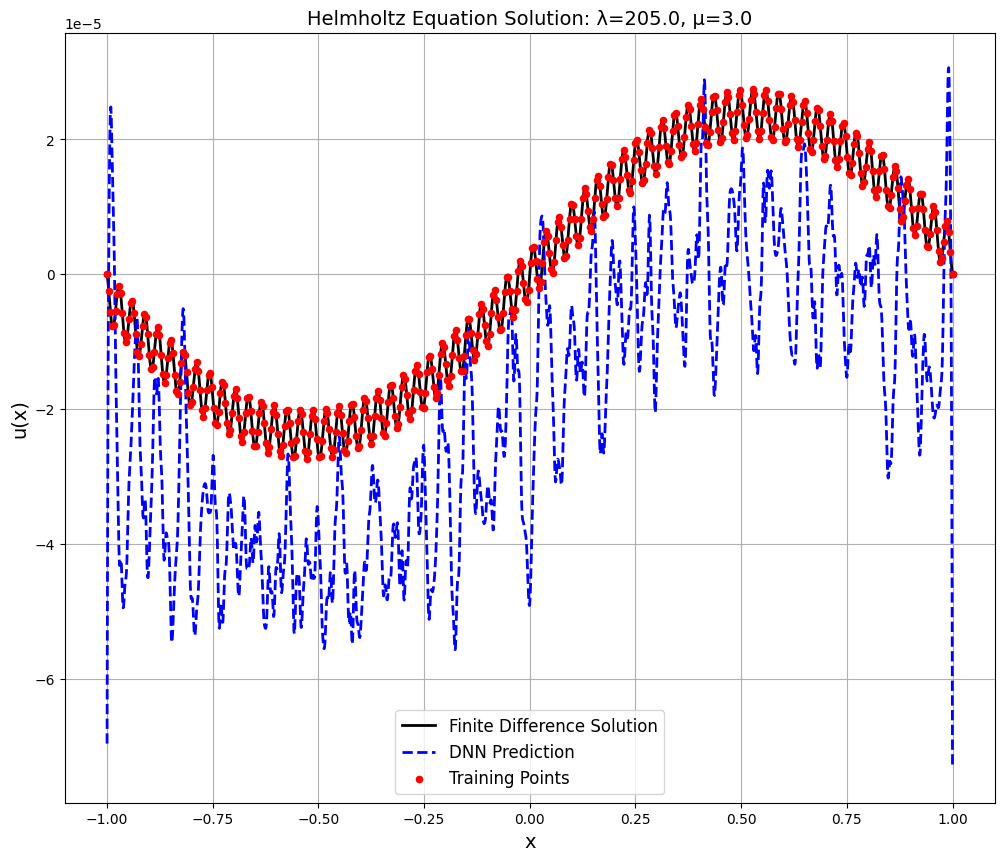

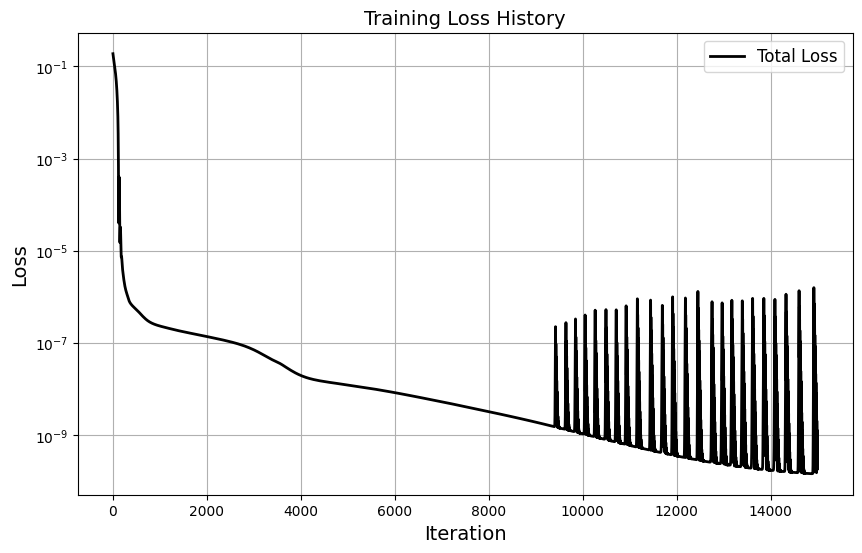

In [ ]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.if_scale_u=False
fourier_solver.physical_information=False
history=fourier_solver.fit(15000)

Total feature dim=256. All Fourier feature frequencies:
tensor([[ 9.1380e-01],
        [ 1.9900e+00],
        [ 3.9274e+00],
        [-5.9207e+00],
        [ 4.4976e+00],
        [ 4.5212e+00],
        [ 6.8624e-01],
        [-2.2543e+00],
        [ 4.0026e+00],
        [ 3.7455e+00],
        [-3.2327e+00],
        [ 3.5358e+00],
        [-1.3719e+00],
        [ 4.2901e+00],
        [ 1.8114e+00],
        [ 1.4472e+00],
        [-3.9057e+00],
        [-4.4543e+00],
        [-1.2092e+00],
        [ 2.3968e+00],
        [-3.2547e+00],
        [ 1.4165e-01],
        [-1.4111e+00],
        [-3.8918e+00],
        [-5.4976e+00],
        [ 5.5477e+00],
        [-4.7890e+00],
        [-1.2922e+00],
        [ 5.2642e+00],
        [-1.5010e+00],
        [ 5.4217e+00],
        [ 3.3828e+00],
        [ 1.8276e+00],
        [ 3.9800e+00],
        [ 7.8548e+00],
        [-1.1841e+01],
        [ 8.9952e+00],
        [ 9.0424e+00],
        [ 1.3725e+00],
        [-4.5085e+00],
        [ 8.0052e+00],
 

C:\Users\hp\AppData\Local\Temp\ipykernel_12824\2441497921.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Iter 500/15000, Loss: 7.537e-01, LR: 1.00e-03
Iter 1000/15000, Loss: 3.828e-01, LR: 1.00e-03
Iter 1500/15000, Loss: 1.965e-01, LR: 1.00e-03
Iter 2000/15000, Loss: 1.014e-01, LR: 1.00e-03
Iter 2500/15000, Loss: 5.654e-02, LR: 1.00e-03
Iter 3000/15000, Loss: 2.750e-02, LR: 1.00e-03
Iter 3500/15000, Loss: 1.637e-02, LR: 1.00e-03
Iter 4000/15000, Loss: 1.079e-02, LR: 1.00e-03
Iter 4500/15000, Loss: 7.513e-03, LR: 1.00e-03
Iter 5000/15000, Loss: 6.350e-03, LR: 1.00e-03
Iter 5500/15000, Loss: 5.949e-03, LR: 1.00e-03
Iter 6000/15000, Loss: 5.853e-03, LR: 1.00e-03
Iter 6500/15000, Loss: 5.832e-03, LR: 1.00e-03
Iter 7000/15000, Loss: 2.452e-03, LR: 1.00e-03
Iter 7500/15000, Loss: 2.059e-03, LR: 1.00e-03
Iter 8000/15000, Loss: 2.026e-03, LR: 1.00e-03
Iter 8500/15000, Loss: 2.080e-03, LR: 1.00e-03
Iter 9000/15000, Loss: 2.024e-03, LR: 1.00e-03
Iter 9500/15000, Loss: 2.023e-03, LR: 9.50e-04
Iter 10000/15000, Loss: 2.023e-03, LR: 9.50e-04
Iter 10500/15000, Loss: 2.023e-03, LR: 9.02e-04
Iter 11000/1

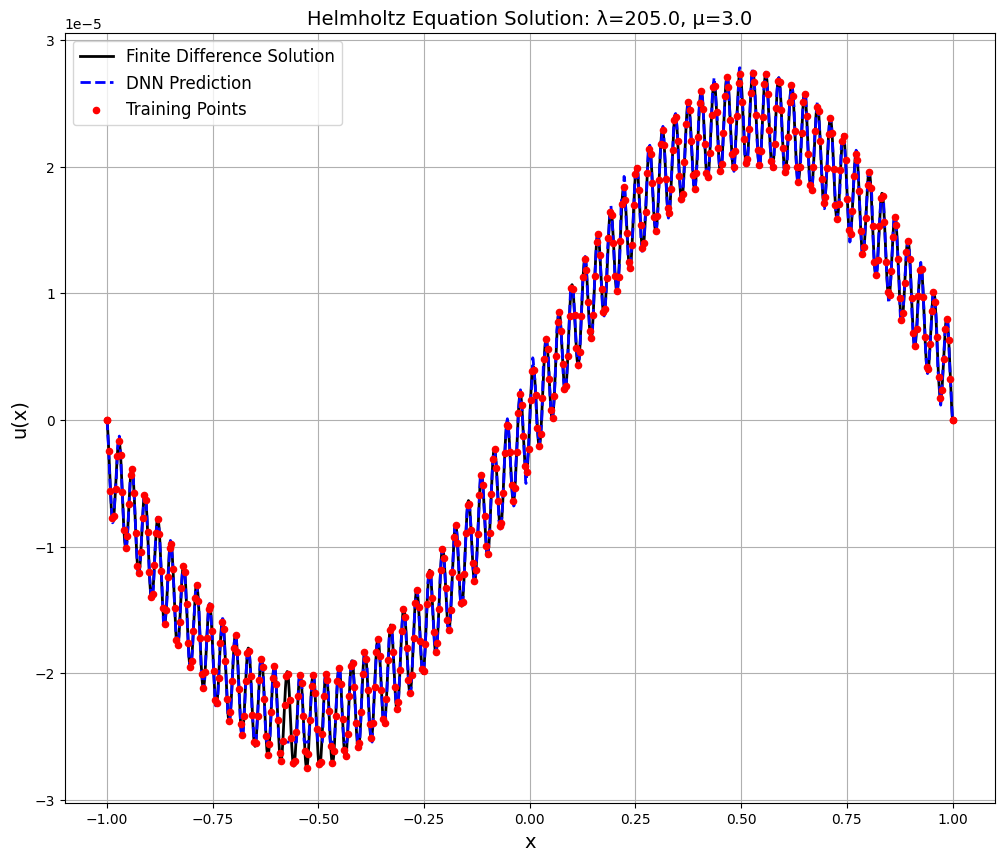

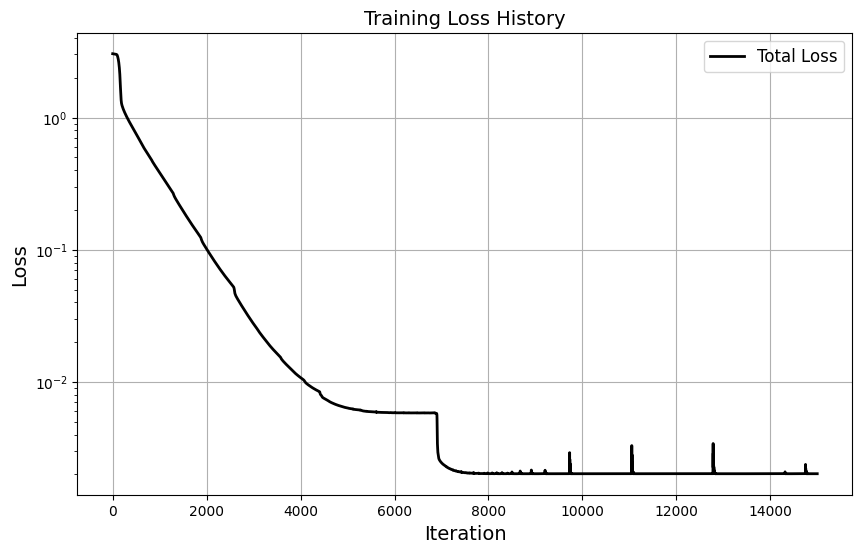

In [10]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.if_scale_u=True
history=fourier_solver.fit(15000)

= 加入物理信息

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_12824\2441497921.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[-1.1317e+00],
        [ 1.8296e+00],
        [ 6.0558e+00],
        [-2.6073e+00],
        [-1.4333e+00],
        [-4.6615e+00],
        [-4.0417e+00],
        [-3.2277e+00],
        [ 2.3983e+00],
        [-5.6727e+00],
        [-4.8564e+00],
        [-1.6130e+00],
        [ 1.4134e+00],
        [-2.3495e+00],
        [-3.7455e-01],
        [-5.8963e+00],
        [-2.6689e+00],
        [ 1.2978e+00],
        [-1.3943e-01],
        [ 5.2348e+00],
        [-5.5820e+00],
        [-1.6763e+00],
        [-8.1421e-01],
        [ 4.9525e+00],
        [ 1.0220e+00],
        [ 4.6479e+00],
        [ 5.1483e+00],
        [-6.1575e+00],
        [-5.2644e+00],
        [-5.5788e-01],
        [ 2.7839e+00],
        [-2.1736e+00],
        [-2.2634e+00],
        [ 3.6592e+00],
        [ 1.2112e+01],
        [-5.2146e+00],
        [-2.8666e+00],
        [-9.3231e+00],
        [-8.0834e+00],
        [-6.4553e+00],
        [ 4.7967e+00],
 

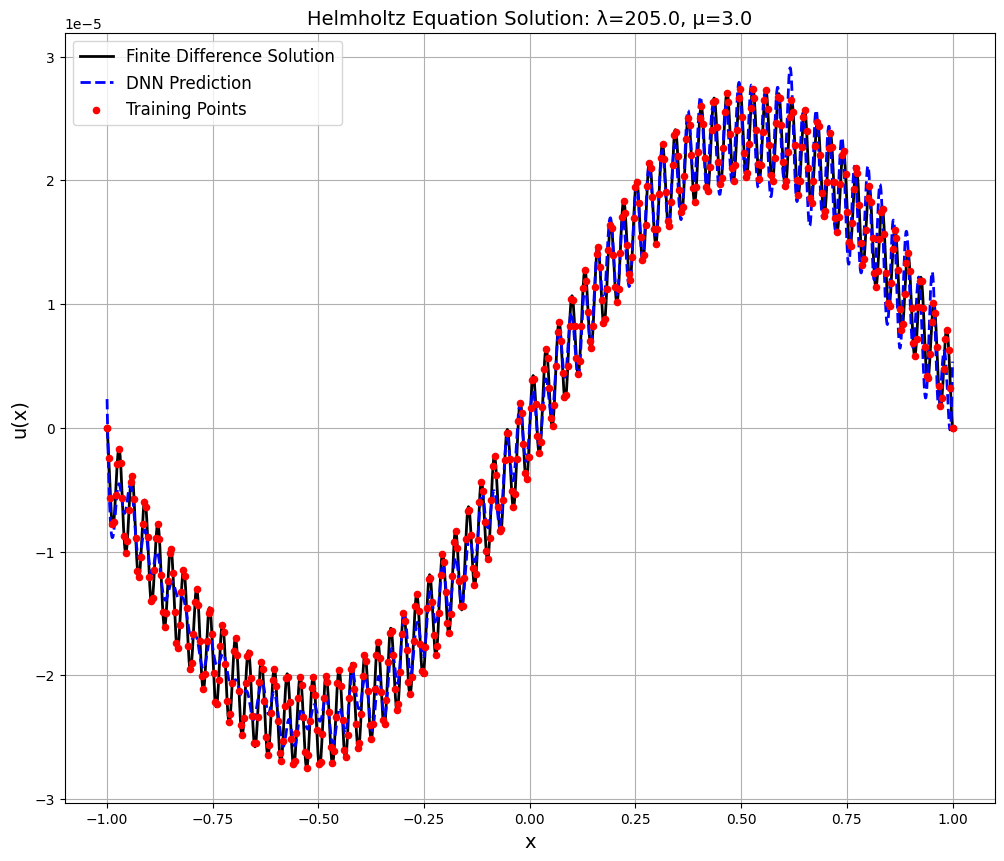

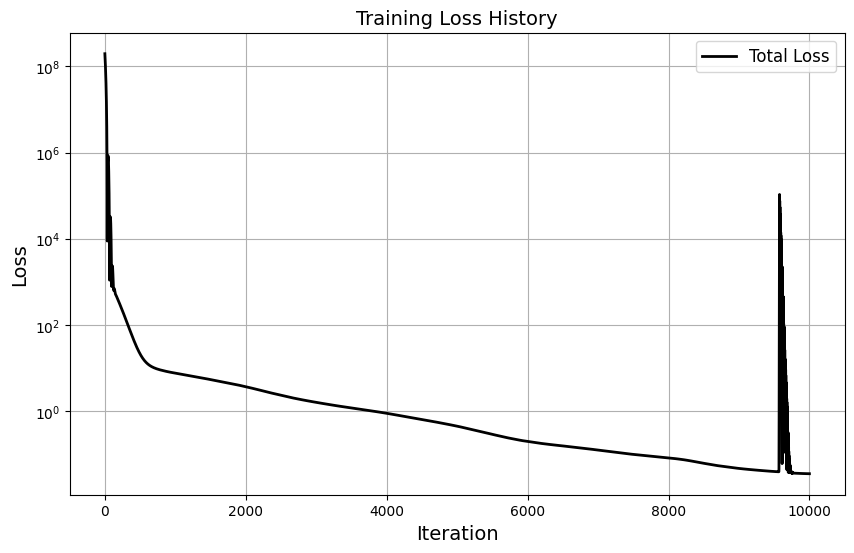

In [41]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.physical_information=True
fourier_solver.if_scale_u=False
history=fourier_solver.fit(10000)

Total feature dim=256. All Fourier feature frequencies:
tensor([[   4.5617],
        [   1.5212],
        [   4.4136],
        [  -6.0920],
        [   4.2317],
        [  -3.2485],
        [   1.1629],
        [  -3.3225],
        [   1.6802],
        [   3.7232],
        [  -5.8791],
        [  -5.1794],
        [  -5.8285],
        [  -6.0672],
        [  -2.0469],
        [   1.0938],
        [   2.3300],
        [   2.6109],
        [   4.1646],
        [   1.4646],
        [   3.5912],
        [  -3.5622],
        [  -4.7877],
        [  -1.2421],
        [  -5.4958],
        [  -3.9271],
        [  -6.2688],
        [   6.0819],
        [   2.3196],
        [  -5.0117],
        [  -5.1274],
        [   0.9989],
        [   9.1234],
        [   3.0423],
        [   8.8272],
        [ -12.1839],
        [   8.4633],
        [  -6.4971],
        [   2.3258],
        [  -6.6450],
        [   3.3605],
        [   7.4464],
        [ -11.7581],
        [ -10.3588],
        [ -11.6570],

C:\Users\hp\AppData\Local\Temp\ipykernel_12824\2441497921.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Iter 500/10000, Total Loss: 1.928e+07, Loss_u: 6.720e-02, Loss_f: 1.928e+07, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 1000/10000, Total Loss: 1.614e+07, Loss_u: 3.413e-02, Loss_f: 1.614e+07, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 1500/10000, Total Loss: 4.805e+07, Loss_u: 9.724e-03, Loss_f: 4.805e+07, LR_u: 5.00e-04, LR_f: 5.00e-05, Ratio: 0.60
Iter 2000/10000, Total Loss: 9.308e+07, Loss_u: 6.783e-04, Loss_f: 9.308e+07, LR_u: 5.00e-04, LR_f: 2.50e-05, Ratio: 0.60
Iter 2500/10000, Total Loss: 9.694e+07, Loss_u: 1.879e-04, Loss_f: 9.694e+07, LR_u: 5.00e-04, LR_f: 2.50e-05, Ratio: 0.60
Iter 3000/10000, Total Loss: 1.104e+08, Loss_u: 1.033e-04, Loss_f: 1.104e+08, LR_u: 5.00e-04, LR_f: 1.25e-05, Ratio: 0.60
Iter 3500/10000, Total Loss: 1.188e+08, Loss_u: 7.679e-05, Loss_f: 1.188e+08, LR_u: 5.00e-04, LR_f: 1.25e-05, Ratio: 0.60
Iter 4000/10000, Total Loss: 1.223e+08, Loss_u: 6.392e-05, Loss_f: 1.223e+08, LR_u: 5.00e-04, LR_f: 6.25e-06, Ratio: 0.60
Iter 4500/10000, Total Lo

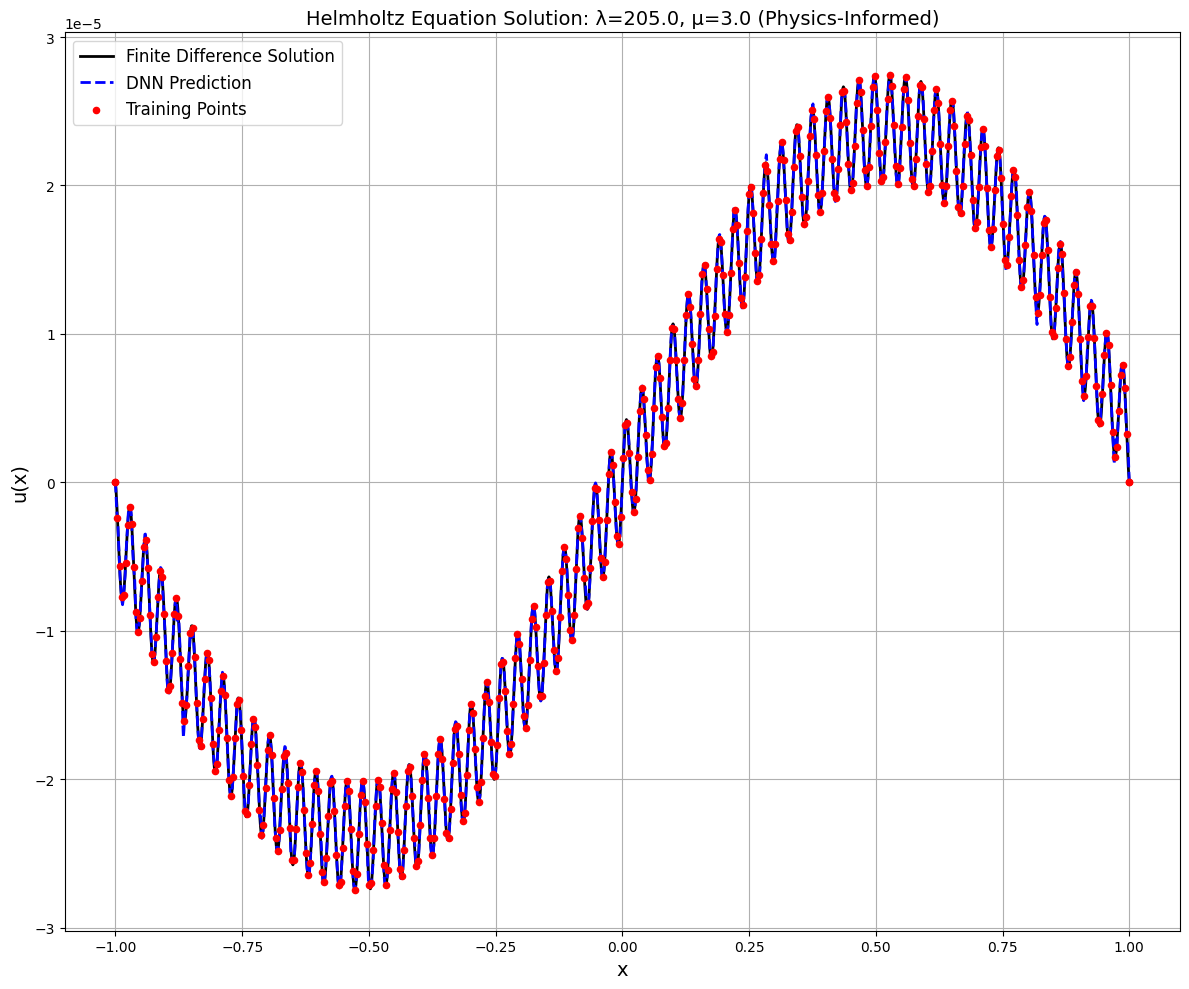

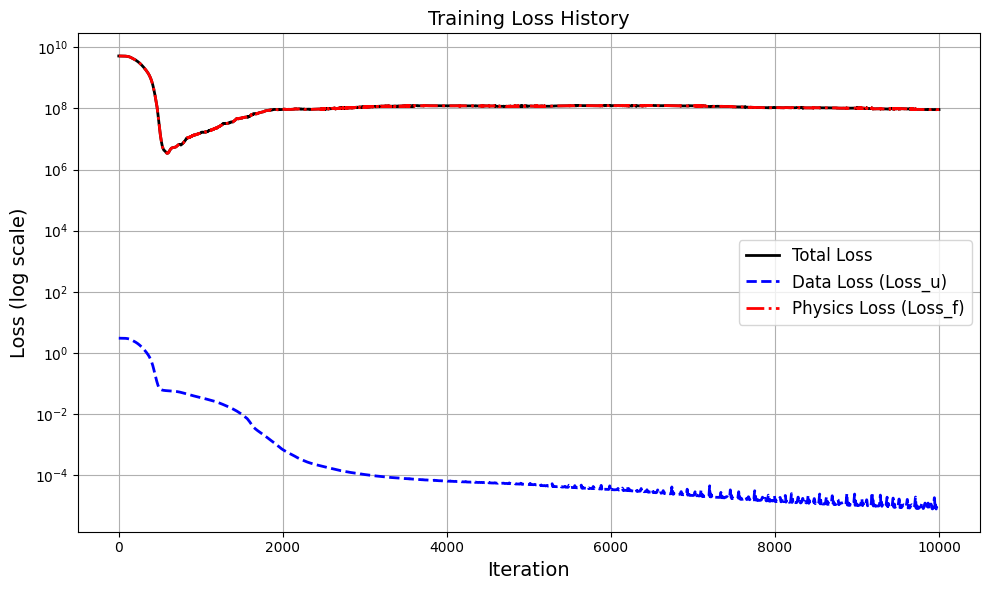

Maximum absolute error: 1.449e-06
Mean absolute error: 8.554e-08


In [53]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.physical_information=True
fourier_solver.if_scale_u=True
history=fourier_solver.fit(10000)